In [113]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import Dataset

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [114]:
train_csv = "/home/tanaka/repos/kaggle_mnist/train.csv"
answer_csv = "/home/tanaka/repos/kaggle_mnist/test.csv"
train_data = pd.read_csv(train_csv)
answer_data = pd.read_csv(answer_csv)

In [115]:
X_train = train_data.sample(frac=0.8, random_state=42)
X_validation = train_data.drop(X_train.index)
display(X_train, X_validation)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
5457,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38509,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25536,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31803,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39863,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17290,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41320,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
760,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19502,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41977,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41983,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
class MNISTDataset(Dataset):
    def __init__(self, directory=None, data=None):
        if directory:
            self.images = pd.read_csv(directory)
            if "label" in self.images:
                self.labels = pd.get_dummies(self.images.loc[:, "label"])
        elif data is not None:
            self.images = data
            if "label" in self.images:
                self.labels = pd.get_dummies(self.images.loc[:, "label"])
    
    def __len__(self):
        return len(self.images.index)
    def __getitem__(self, idx): 
        
        return (torch.tensor(self.images.iloc[idx, 1:], dtype=torch.float32).reshape((1, 28, 28)),
                torch.tensor(self.labels.iloc[idx].values).type(torch.float) if len(self.labels) else None)
    

In [117]:
batch_size = 64
epochs = 10
lr = 0.01
train_dataset = MNISTDataset(data = X_train)
validation_dataset = MNISTDataset(data = X_validation)
data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_loader_validation = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)


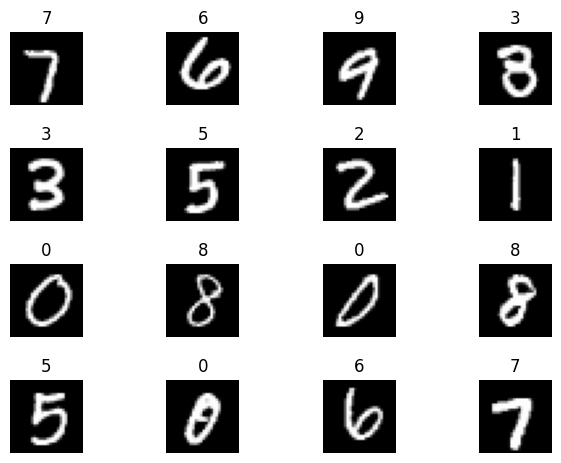

In [118]:
# Iterating through the DataLoader
train_features, train_labels = next(iter(data_loader_train))

# Visualizing the data
num_plots = 16
sqrt_plots = int(num_plots**(1/2))
fig, ax = plt.subplots(sqrt_plots, sqrt_plots)
fig.tight_layout(h_pad=1)
for idx, feature in enumerate(train_features[:num_plots]):
    ax[idx//sqrt_plots, idx%sqrt_plots].imshow(feature.squeeze(), cmap="gray")
    ax[idx//sqrt_plots, idx%sqrt_plots].set_title(label=(train_labels[idx]==1).nonzero().item())
    ax[idx//sqrt_plots, idx%sqrt_plots].axis('off')


In [119]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device: {device}")

Device: cpu


In [120]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        

In [121]:
model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [122]:
def train_loop(data_loader, model, loss_fn, optimizer):
    for batch, (X, y) in enumerate(data_loader):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y, y_pred.softmax(dim=-1))
        # backpropagation
        loss.backward()
        optimizer.step()
        
        
        if batch%524==0:
            print(f"Batch {batch} of {len(data_loader)}, loss: {loss.item()}")
            
def test_loop(data_loader, model, loss_fn):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y)
            # print(y_pred.argmax(1), y.argmax(1))
            correct += (y_pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
            # break
    print(f"Correct: {correct} out of {size}, average loss: {test_loss/num_batches}")

In [123]:
for t in range(epochs):
    print(f"Epoch {t+1} \n --------------")
    train_loop(data_loader_train, model, loss_fn, optimizer)
    test_loop(data_loader_validation, model, loss_fn)


Epoch 1 
 --------------
Batch 0 of 525, loss: 2.330888271331787
Batch 524 of 525, loss: 1.7936500310897827
Correct: 4830.0 out of 8400, average loss: 13.849529266357422
Epoch 2 
 --------------
Batch 0 of 525, loss: 1.9383565187454224
Batch 524 of 525, loss: 1.7953158617019653
Correct: 5571.0 out of 8400, average loss: 9.954060554504395
Epoch 3 
 --------------
Batch 0 of 525, loss: 1.8437042236328125
Batch 524 of 525, loss: 1.6487202644348145
Correct: 5650.0 out of 8400, average loss: 9.618294715881348
Epoch 4 
 --------------
Batch 0 of 525, loss: 1.7344589233398438
Batch 524 of 525, loss: 1.8682790994644165
Correct: 5662.0 out of 8400, average loss: 9.238930702209473
Epoch 5 
 --------------
Batch 0 of 525, loss: 1.789275884628296
Batch 524 of 525, loss: 1.7451311349868774
Correct: 5686.0 out of 8400, average loss: 8.515922546386719
Epoch 6 
 --------------
Batch 0 of 525, loss: 1.7580275535583496
Batch 524 of 525, loss: 1.6341865062713623
Correct: 6427.0 out of 8400, average loss:

2


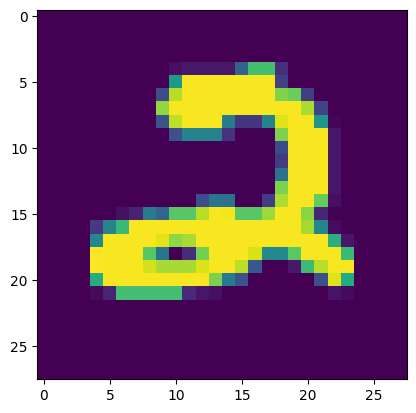

0


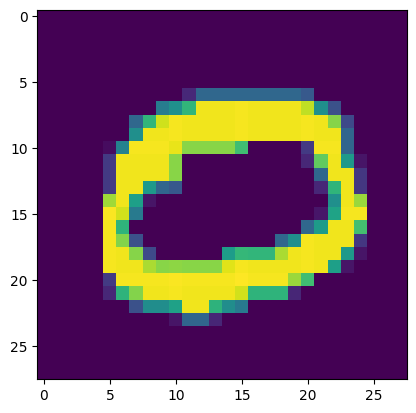

4


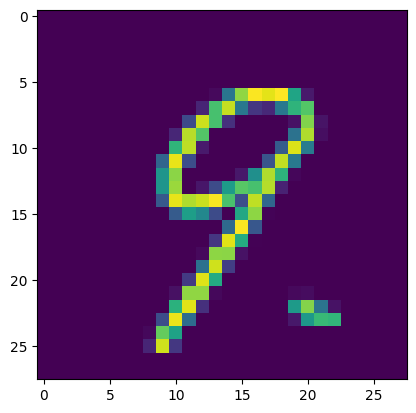

7


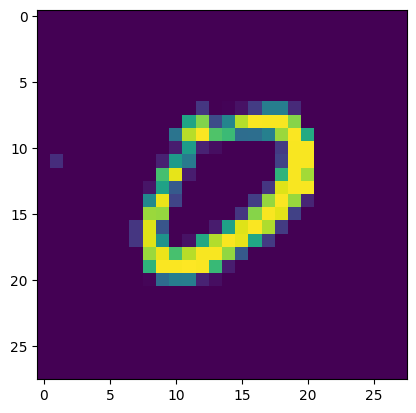

3


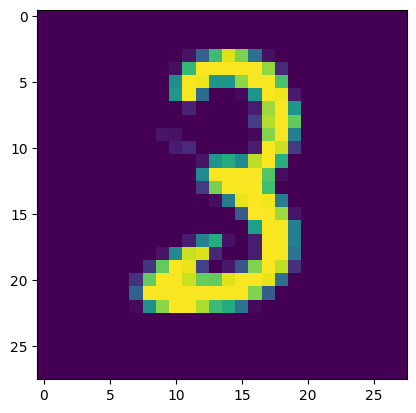

7


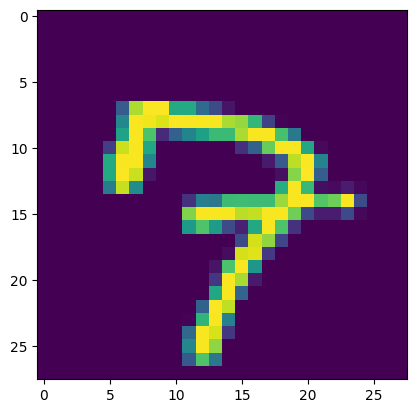

0


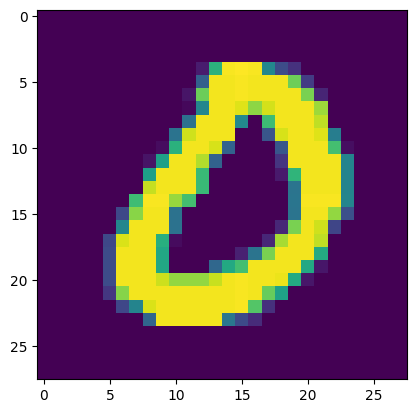

3


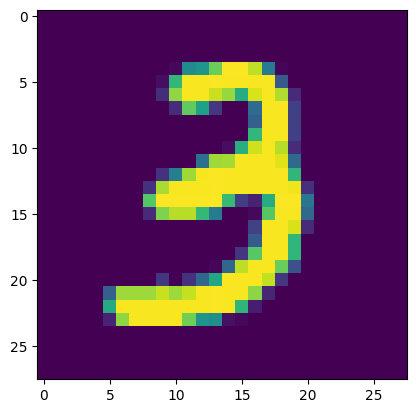

0


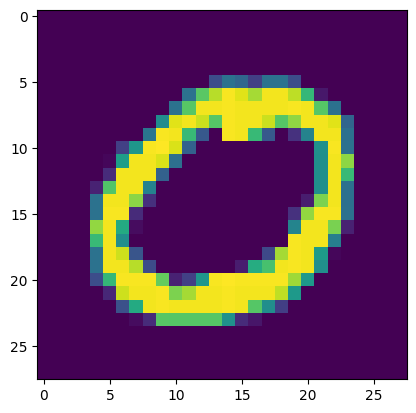

3


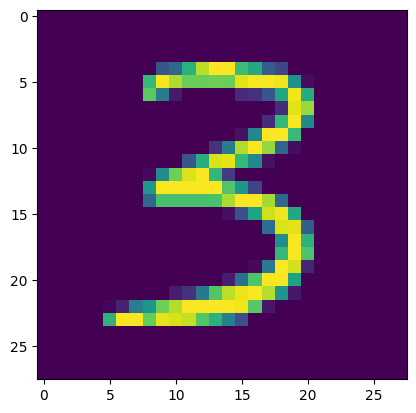

In [125]:
with torch.no_grad():
    for idx, X in answer_data[:10].iterrows():
        y_pred = model(torch.tensor(X.values).unsqueeze(dim=0).type(torch.float))
        ans = y_pred.argmax(1).item()
        print(ans)
        plt.imshow(np.array(X).reshape(28, 28))
        plt.show()